# Code Abstract
The logical Qubit representation for a \[\[4, 1, 2\]\] stabilizer code is given by the logical operators:
$ {\left|{0}\right\rangle}_{L} = \frac{1}{\sqrt{2}}\Bigl({\left|{0000}\right\rangle}+{\left|{1111}\right\rangle}\Bigr) $
$ {\left|{1}\right\rangle}_{L} = \frac{1}{\sqrt{2}}\Bigl({\left|{0101}\right\rangle}+{\left|{1010}\right\rangle}\Bigr) $


## Code imports

In [715]:
import random
import qiskit
import qiskit.tools.parallel

qiskit.__qiskit_version__

from qiskit.tools.visualization import plot_histogram
from qiskit.visualization import plot_state_city, plot_bloch_multivector
from qiskit.visualization import plot_state_paulivec, plot_state_hinton
from qiskit.visualization import plot_bloch_vector
from qiskit.visualization import plot_state_qsphere

from qiskit.providers.ibmq import least_busy

import qiskit.quantum_info as qi

from numpy import *
from qiskit import *
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit_aer import AerSimulator

## Qubit metadata definition (classes)
The classes are organized as follows:
- **LogicalCircuitDefinition**: Circuit definition for the logical Qubits
- **LogicalQubitDefinition**: Represents the logical Qubit we are creating as defines helper methods to create and maintain the data qubits
- **SurfaceCode**: Helpful method for creating the Surface code circuits
- **ErrorSimulation**: Simulates different type of errors

In [716]:
class LogicalCircuitDefinition:
    pass

class LogicalQubitDefinition:
    def __init__(self, lqc: LogicalCircuitDefinition):
        self.n = lqc.n
        self.m = lqc.m

        self.data_qu = QuantumRegister(lqc.n)
        self.ancilla_qu = AncillaRegister(lqc.m)
        self.classical_bits = ClassicalRegister(lqc.m)

        self.qc = lqc.qc
        self.qc.add_register(self.data_qu)
        self.qc.add_register(self.ancilla_qu)
        self.qc.add_register(self.classical_bits)

        # Put all qubits into ground state
        for j in range(lqc.n):
            self.qc.reset(self.data_qu[j])
        for j in range(lqc.m):
            self.qc.reset(self.ancilla_qu[j])

# Logical Quantum circuit representation
class LogicalCircuitDefinition:
    def __init__(self, n: int, m: int, d: int):
        self._nbLQubits_0 = 0
        self._nbLQubits_1 = 0

        self.n = n
        self.m = m
        self.d = d

        self.lqubits = []
        self.qc = QuantumCircuit()

    # Creates the logical qubit state |0> for the given circuit
    def createSurfaceLogicalQubit_0(self, entangled = False) -> LogicalQubitDefinition:
        lq = LogicalQubitDefinition(self)

        # Entangle all the Bits using Bell's 0000-1111 code base
        if not entangled:
            for d in range(self.n):
                if d % 2 == 0:
                    self.qc.h(lq.data_qu[d])
                else:
                    self.qc.cx(lq.data_qu[d-1], lq.data_qu[d])
        else:
            for d in range(self.n):
                if d == 0:
                    self.qc.h(lq.data_qu[d])
                else:
                    self.qc.cx(lq.data_qu[d-1], lq.data_qu[d])

        self.lqubits.append(lq)
        # increase the number of logical qubits in the circuit
        self._nbLQubits_0 += 1
        return lq

    # Creates the logical qubit state |1> for the given circuit
    def createSurfaceLogicalQubit_1(self, entangled = False) -> LogicalQubitDefinition:
        lq = LogicalQubitDefinition(self)

        # Entagles using Bell's basis 0101-1010
        if not entangled:
            for d in range(self.n):
                if d % 2 == 0:
                    self.qc.h(lq.data_qu[d])
                else:
                    self.qc.x(lq.data_qu[d])
                    self.qc.cx(lq.data_qu[d-1], lq.data_qu[d])
        else:
            for d in range(self.n):
                if d == 0:
                    self.qc.h(lq.data_qu[d])
                else:
                    self.qc.x(lq.data_qu[d])
                    self.qc.cx(lq.data_qu[d-1], lq.data_qu[d])

        self.lqubits.append(lq)
        # increase the number of logical qubits in the circuit
        self._nbLQubits_1 += 1
        return lq

    def getNumberOfLogicalQubits(self) -> int:
        return self._nbLQubits_1 + self._nbLQubits_0

    def getNumberLogicalZeros(self) -> int:
        return self._nbLQubits_0

    def getNumberLogicalOnes(self) -> int:
        return self._nbLQubits_1

# Surface code definitions
class SurfaceCode:
    def __init__(self, lqc: LogicalCircuitDefinition):
        self.lqc = lqc
        self.simulator = Aer.get_backend('qasm_simulator')

    def check4BitFlip(self, lqu: LogicalQubitDefinition):
        # clean the ancilla qubit for error check
        for j in range(self.lqc.m):
            self.lqc.qc.reset(lqu.ancilla_qu[j])
            self.lqc.qc.h(lqu.ancilla_qu[j])

        self.lqc.qc.barrier()

        ancilla_idxeven: int = 0
        ancilla_idxodd: int = 1
        for k in range(self.lqc.n):
            if k % self.lqc.d == 0:
                self.lqc.qc.cz(lqu.data_qu[k], lqu.ancilla_qu[ancilla_idxeven])
                if ancilla_idxeven % self.lqc.d == 0 and k > 0:
                    ancilla_idxeven += 1
            else:
                if (ancilla_idxodd+1) % self.lqc.d == 0:
                    ancilla_idxodd += 1
                self.lqc.qc.cz(lqu.data_qu[k], lqu.ancilla_qu[ancilla_idxodd])

        self.lqc.qc.barrier()
        for j in range(self.lqc.m):
            self.lqc.qc.h(lqu.ancilla_qu[j])
            self.lqc.qc.measure(lqu.ancilla_qu[j], lqu.classical_bits[j])

        return execute(self.lqc.qc, backend=self.simulator, shots=1024).result()

    def check4PhaseFlip(self, lqu: LogicalQubitDefinition):
        # clean the ancilla qubit for error check
        for j in range(self.lqc.m):
            #self.lqc.qc.reset(lqu.ancilla_qu[j])
            self.lqc.qc.h(lqu.ancilla_qu[j])
        # Hadamard before the read-out
        for d in range(self.lqc.n):
            self.lqc.qc.h(lqu.data_qu[d])

        self.lqc.qc.barrier()

        ancilla_idx: int = 1
        data_idx: int = 0
        while data_idx < self.lqc.n:
            print(f"Data index[{data_idx}] <-> Ancilla index[{ancilla_idx}]")
            self.lqc.qc.cx(lqu.data_qu[data_idx], lqu.ancilla_qu[ancilla_idx])

            # Middle Pauli Z-gate
            if data_idx % self.lqc.n and data_idx > self.lqc.d:
                ancilla_idx += self.lqc.d

            data_idx += 1

        self.lqc.qc.barrier()
        for j in range(self.lqc.m):
            self.lqc.qc.h(lqu.ancilla_qu[j])
            self.lqc.qc.measure(lqu.ancilla_qu[j], lqu.classical_bits[j])

        # Hadamard before the read.out
        for d in range(self.lqc.n):
            self.lqc.qc.h(lqu.data_qu[d])

        return execute(self.lqc.qc, backend=self.simulator, shots=1024).result()

BITFLIP_IDX = 0
PHASEFLIP_IDX = 1
# Error simulation
class ErrorSimulation:
    def __init__(self, lqc: LogicalCircuitDefinition):
        self.l_circuit = lqc
        self.sc = SurfaceCode(lqc)

    def addBitFlipError(self, lqu: LogicalQubitDefinition, at: int = -1):
        if at > self.l_circuit.n:
            at = self.l_circuit.n -1

        idx: int = 0
        if at < 0:
            idx = random.randint(0,self.l_circuit.n)
        else:
            idx = at

        self.l_circuit.qc.x(lqu.data_qu[idx])

    def addPhaseFlipError(self, lqu: LogicalQubitDefinition):
        idx: int = random.randint(0,self.l_circuit.n)
        self.l_circuit.qc.z(lqu.data_qu[idx])

    def generateNoise(self, lqu: LogicalQubitDefinition):
        errtype: int = random.randint(BITFLIP_IDX,PHASEFLIP_IDX)

        if errtype == PHASEFLIP_IDX:
            self.addPhaseFlipError(lqu)
            self.l_circuit.qc.barrier()
            return self.sc.check4PhaseFlip(lqu)
        elif errtype == BITFLIP_IDX:
            self.addBitFlipError(lqu)
            self.l_circuit.qc.barrier()
            return self.sc.check4BitFlip(lqu)

## Simulate different circuits with surface code implemented
This section implements 4 different use cases. The first two simply create the error correction circuit and measure its ancillas for stabilization

### Main definition

In [717]:
from qiskit_aer import QasmSimulator

nb_n: int = 4
nb_m: int = 3
nb_d: int = 2
entangle_qubits = True

### Case 1: Logical bit "0" circuit

In [718]:
# prepares the logical qubits for the stabilizer code [[4,0,2]]
# this includes 4 qubits, 2 ancilla qubits and 2 classical bits per logical qubits
l_circuit1 = LogicalCircuitDefinition(nb_n, nb_m, nb_d)
lq0 = l_circuit1.createSurfaceLogicalQubit_0(entangle_qubits)
#lq1 = l_circuit.createSurfaceLogicalQubit_1()
l_circuit1.qc.barrier()
print(f"# of logical qubits: {l_circuit1.getNumberOfLogicalQubits()}")
print(f"# of logical 0's: {l_circuit1.getNumberLogicalZeros()}")
print(f"# of logical 1's: {l_circuit1.getNumberLogicalOnes()}")

# State vector representation
qasmSimulator1 = QasmSimulator()
stv1 = qiskit.quantum_info.Statevector.from_instruction(l_circuit1.qc)
execute(l_circuit1.qc, qasmSimulator1)
stv1.draw('latex', prefix='\\left|{\\Phi}\\right\\rangle=')

# of logical qubits: 1
# of logical 0's: 1
# of logical 1's: 0


<IPython.core.display.Latex object>

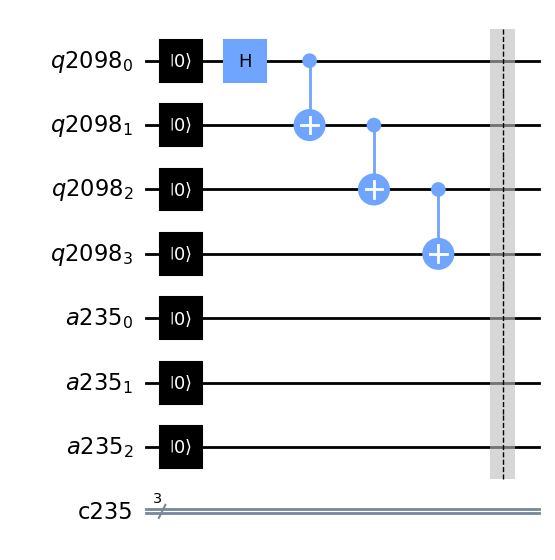

In [719]:
l_circuit1.qc.draw(output='mpl')

Data index[0] <-> Ancilla index[1]
Data index[1] <-> Ancilla index[1]
Data index[2] <-> Ancilla index[1]
Data index[3] <-> Ancilla index[1]


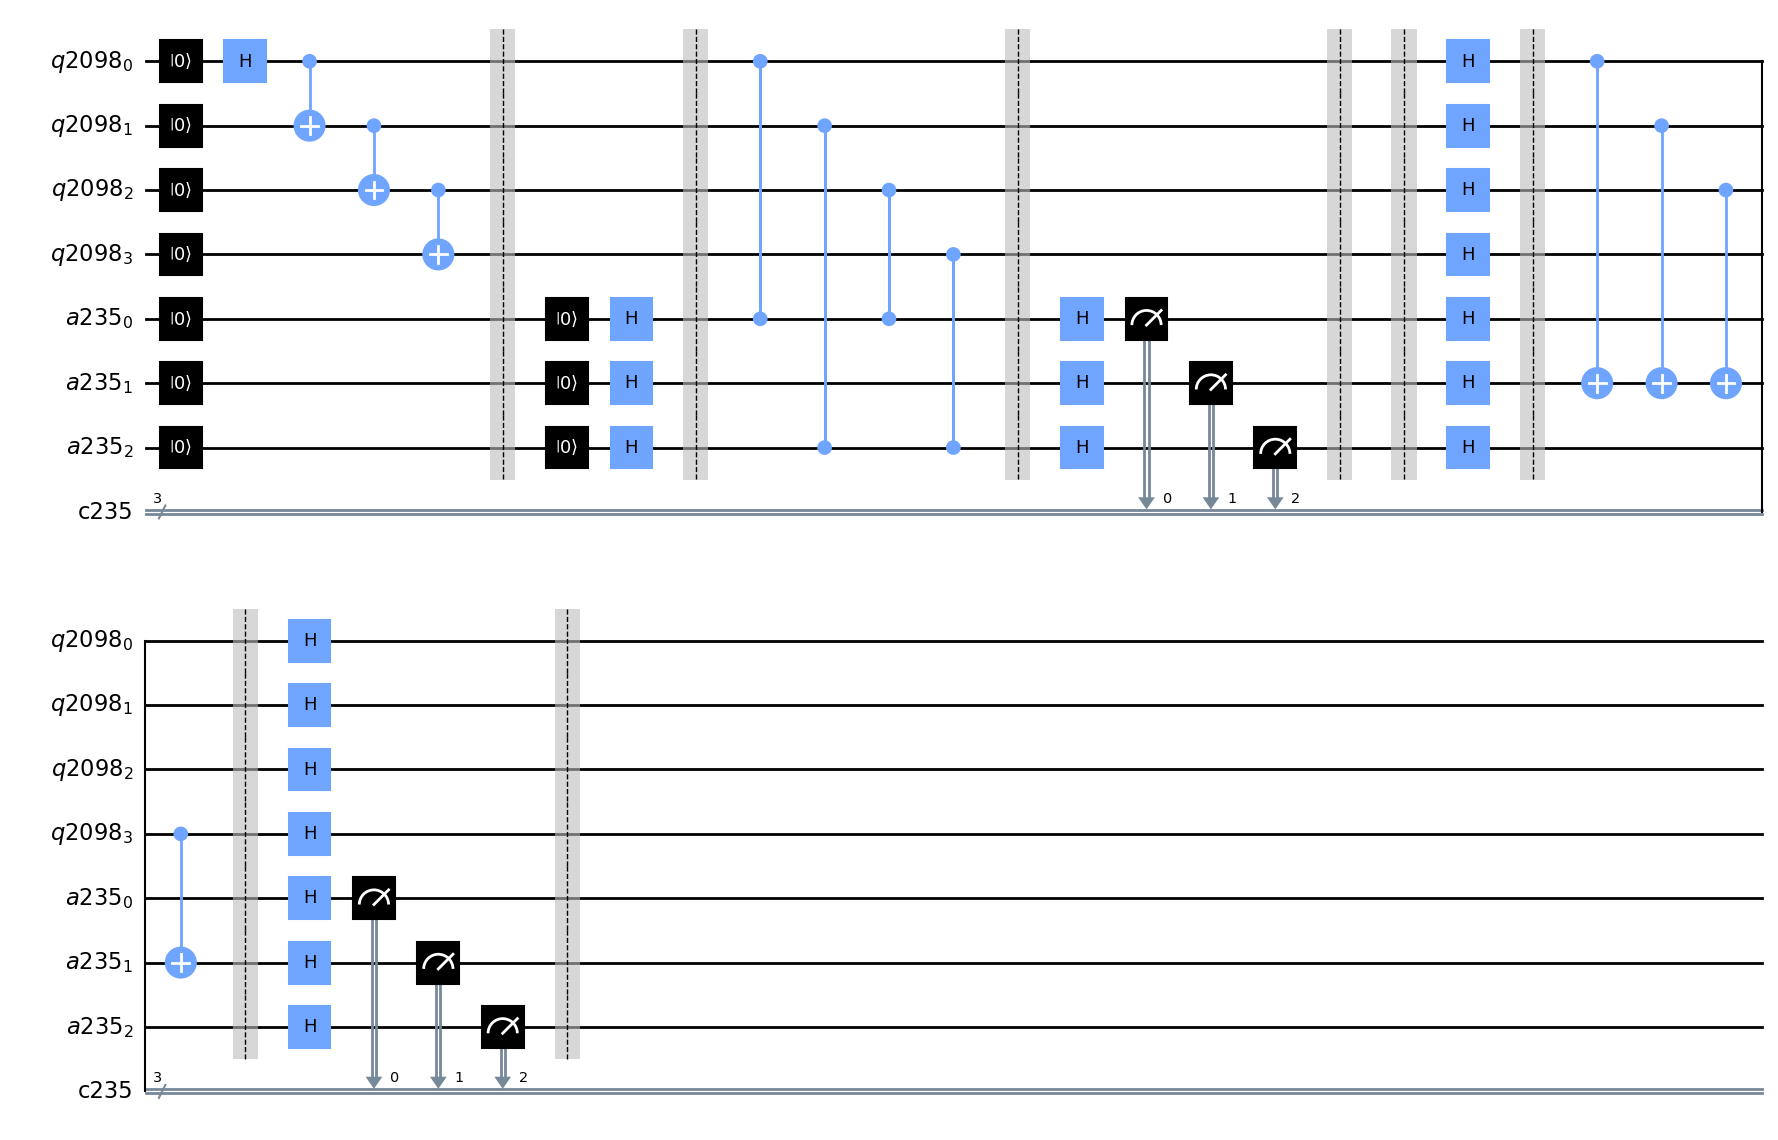

In [720]:
sc = SurfaceCode(l_circuit1)
sc.check4BitFlip(lq0)
l_circuit1.qc.barrier()

l_circuit1.qc.barrier()
result = sc.check4PhaseFlip(lq0)
l_circuit1.qc.barrier()

l_circuit1.qc.draw(output='mpl')

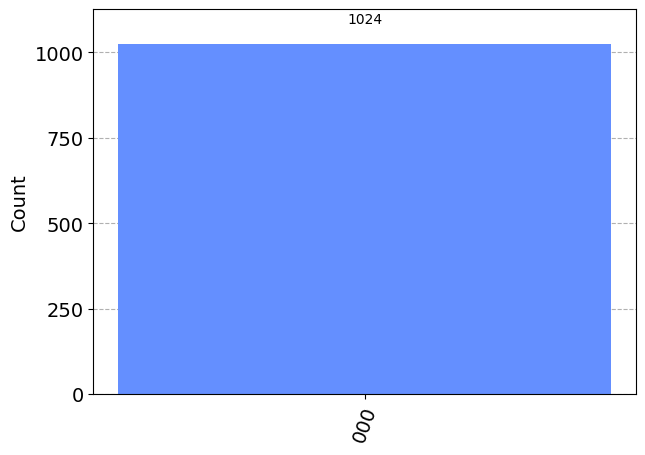

In [721]:
plot_histogram(result.get_counts(l_circuit1.qc))

### Case 2: Logical qubit "1" circuit

In [722]:
# creates a logical "1"
l_circuit2 = LogicalCircuitDefinition(nb_n, nb_m, nb_d)
lq1 = l_circuit2.createSurfaceLogicalQubit_1(entangle_qubits)
l_circuit2.qc.barrier()
print(f"# of logical qubits: {l_circuit2.getNumberOfLogicalQubits()}")
print(f"# of logical 0's: {l_circuit2.getNumberLogicalZeros()}")
print(f"# of logical 1's: {l_circuit2.getNumberLogicalOnes()}")

# State vector representation
qasmSimulator1 = QasmSimulator()
stv1 = qiskit.quantum_info.Statevector.from_instruction(l_circuit2.qc)
execute(l_circuit2.qc, qasmSimulator1)
stv1.draw('latex', prefix='\\left|{\\Phi}\\right\\rangle=')

# of logical qubits: 1
# of logical 0's: 0
# of logical 1's: 1


<IPython.core.display.Latex object>

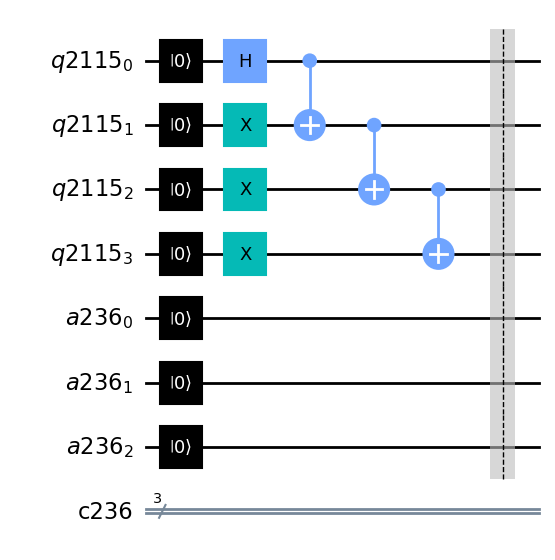

In [723]:
l_circuit2.qc.draw(output='mpl')

Data index[0] <-> Ancilla index[1]
Data index[1] <-> Ancilla index[1]
Data index[2] <-> Ancilla index[1]
Data index[3] <-> Ancilla index[1]


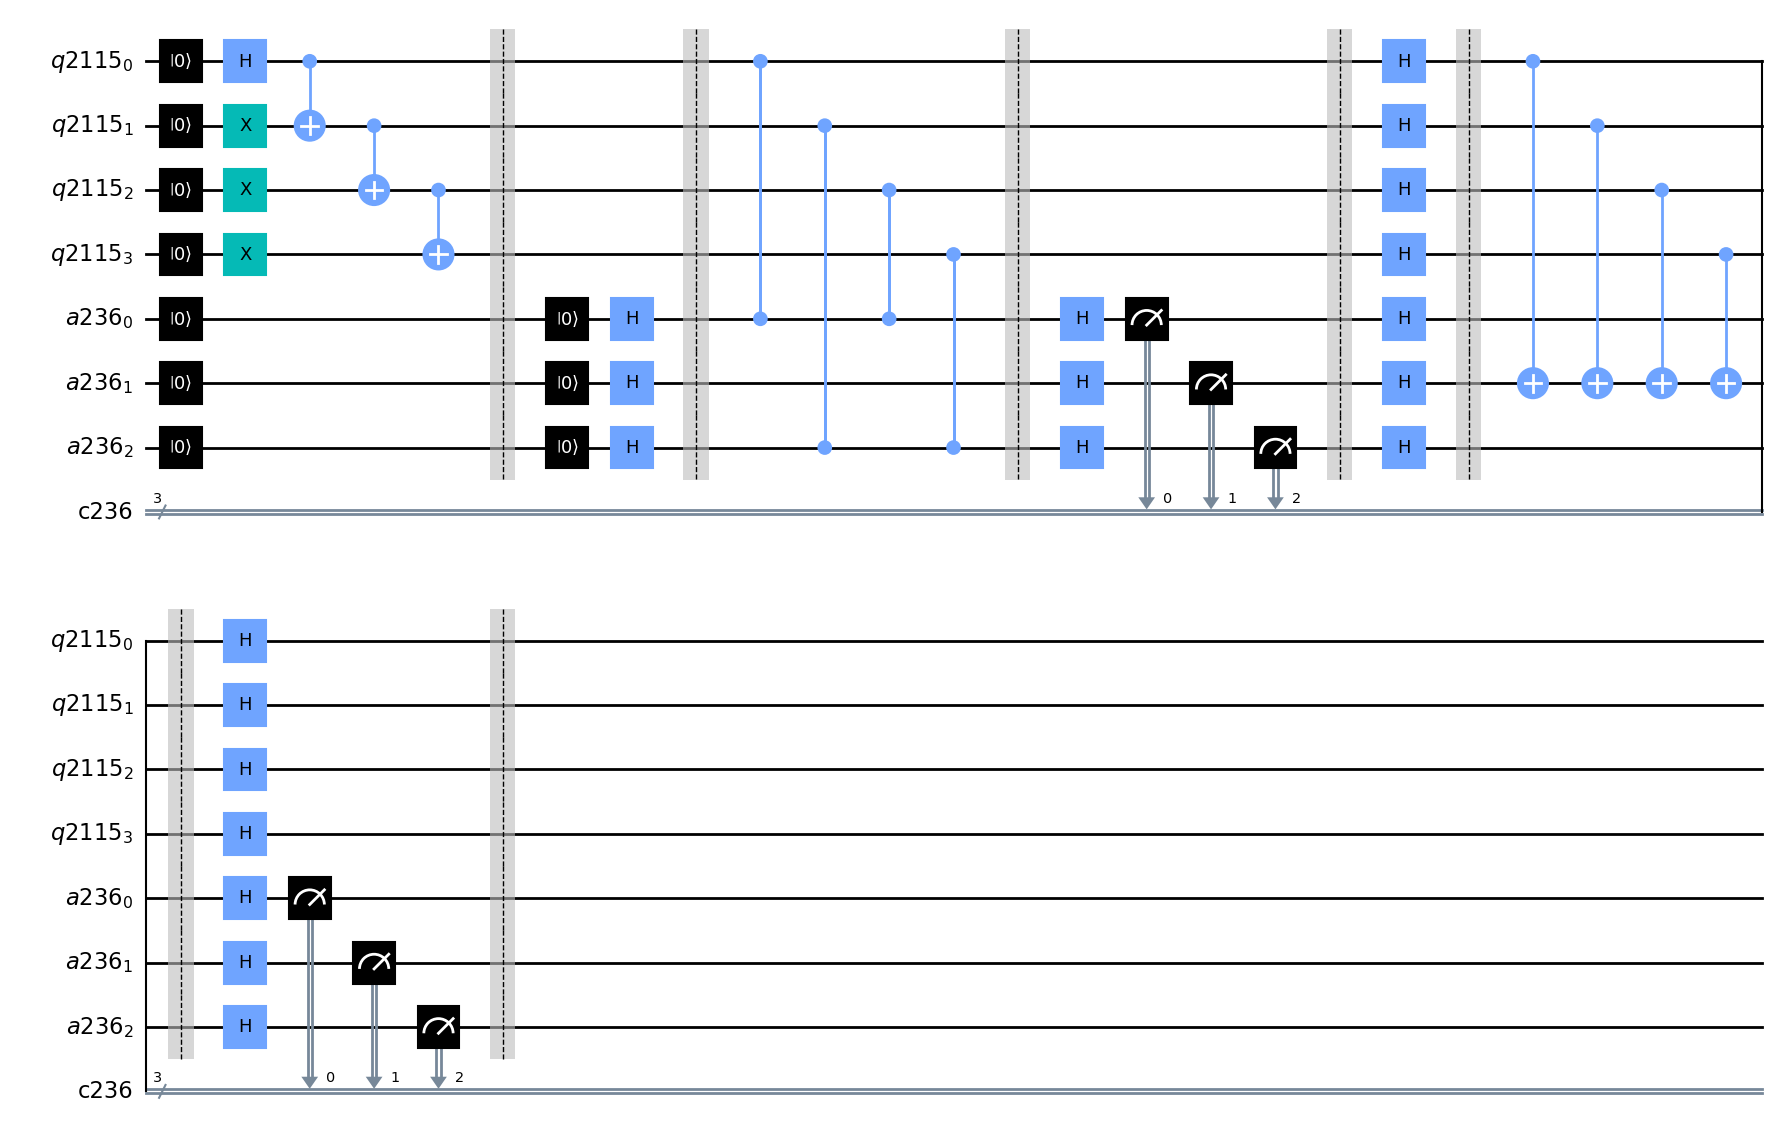

In [724]:
sc2 = SurfaceCode(l_circuit2)
sc2.check4BitFlip(lq1)
l_circuit2.qc.barrier()
result = sc2.check4PhaseFlip(lq1)
l_circuit2.qc.barrier()

l_circuit2.qc.draw(output='mpl')

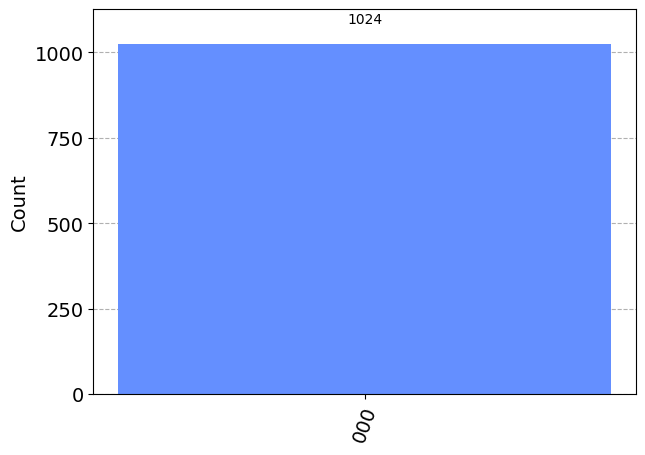

In [725]:
plot_histogram(result.get_counts(l_circuit2.qc))

### Case 3: Simulates the logical qubit "0" with a random bit-flip error introduced

# of logical qubits: 1
# of logical 0's: 1
# of logical 1's: 0


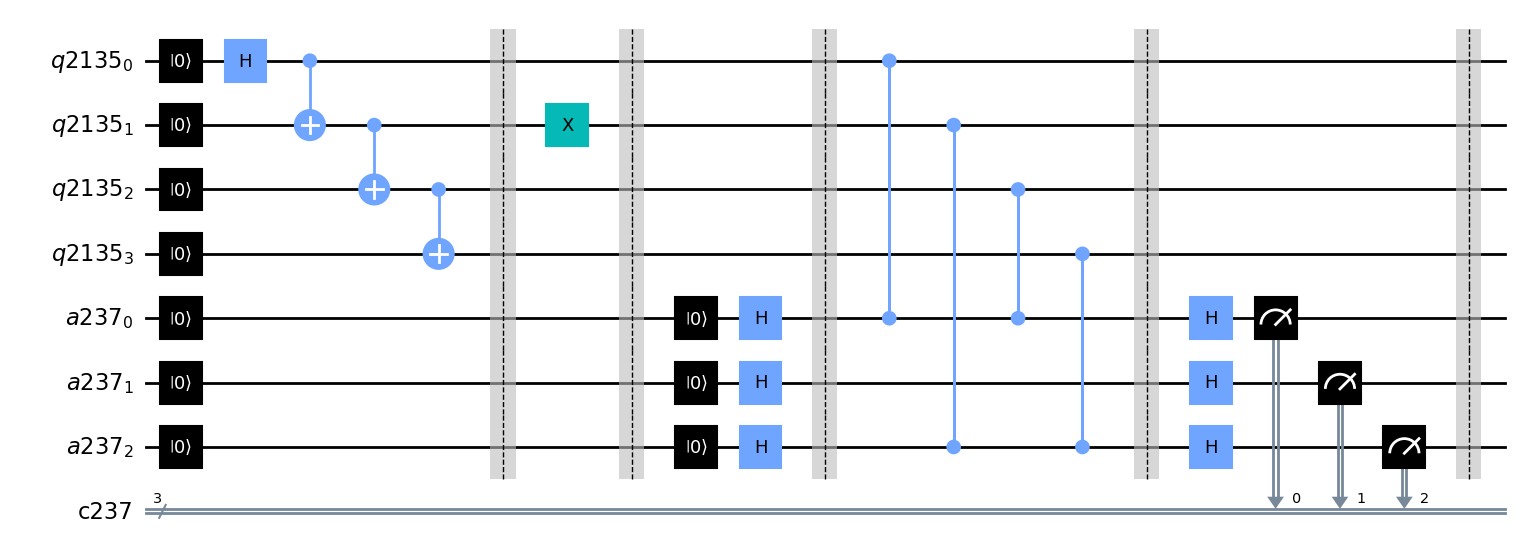

In [726]:
# X error simulation for logical qubit "0"
l_circuit3 = LogicalCircuitDefinition(nb_n, nb_m, nb_d)
lq0 = l_circuit3.createSurfaceLogicalQubit_0(entangle_qubits)
l_circuit3.qc.barrier()
print(f"# of logical qubits: {l_circuit3.getNumberOfLogicalQubits()}")
print(f"# of logical 0's: {l_circuit3.getNumberLogicalZeros()}")
print(f"# of logical 1's: {l_circuit3.getNumberLogicalOnes()}")

# Error simulation for logical qubit "0"
errSimul0 = ErrorSimulation(l_circuit3)
result = errSimul0.generateNoise(lq0)

l_circuit3.qc.barrier()
l_circuit3.qc.draw(output='mpl')

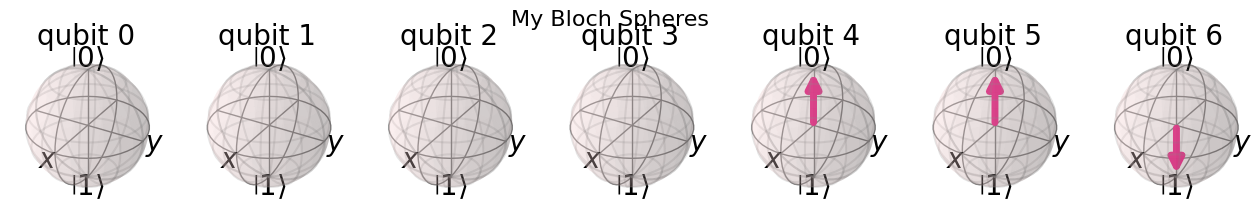

In [727]:
backend = BasicAer.get_backend('statevector_simulator') # the device to run on
result_statevector = backend.run(transpile(l_circuit3.qc, backend)).result()
psi = result_statevector.get_statevector(l_circuit3.qc)
plot_bloch_multivector(psi, title="My Bloch Spheres")

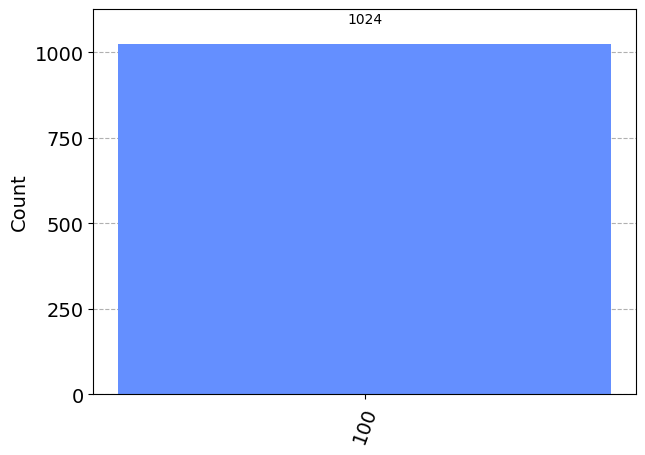

In [728]:
plot_histogram(result.get_counts(l_circuit3.qc))

### Case 4: Same as _case 3_, but it introduces a bit-phase error

# of logical qubits: 1
# of logical 0's: 1
# of logical 1's: 0
Data index[0] <-> Ancilla index[1]
Data index[1] <-> Ancilla index[1]
Data index[2] <-> Ancilla index[1]
Data index[3] <-> Ancilla index[1]


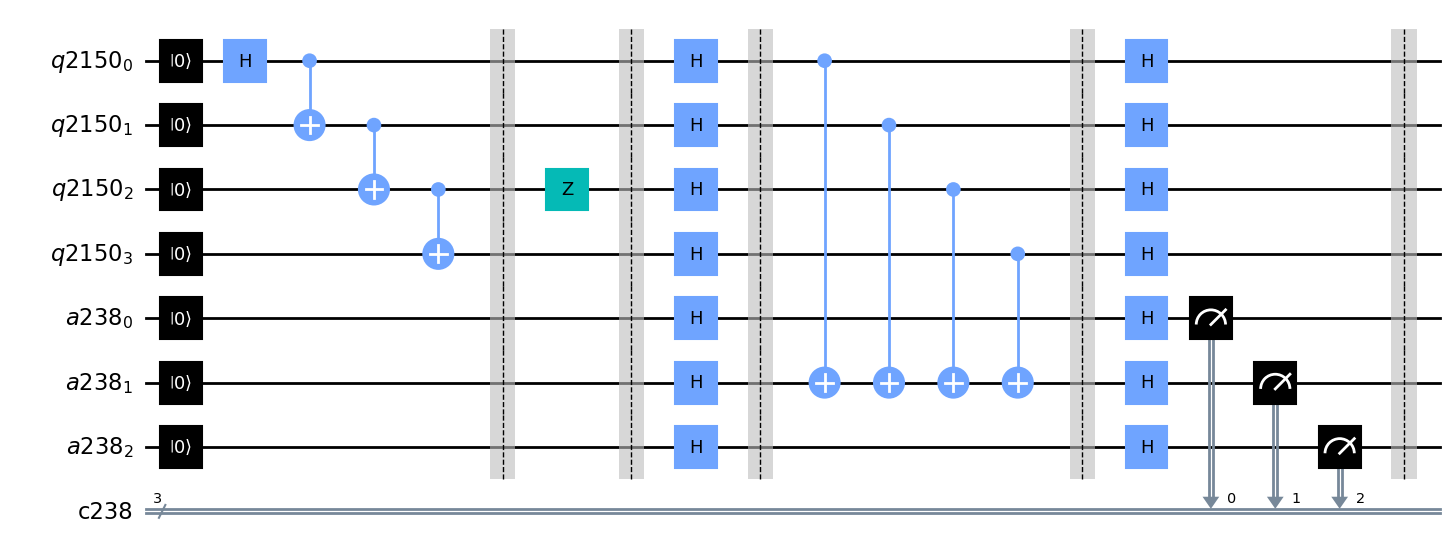

In [729]:
# Z-type of error simulation for logical qubit "0"
l_circuit4 = LogicalCircuitDefinition(nb_n, nb_m, nb_d)
lq0 = l_circuit4.createSurfaceLogicalQubit_0(entangle_qubits)
l_circuit4.qc.barrier()
print(f"# of logical qubits: {l_circuit4.getNumberOfLogicalQubits()}")
print(f"# of logical 0's: {l_circuit4.getNumberLogicalZeros()}")
print(f"# of logical 1's: {l_circuit4.getNumberLogicalOnes()}")

# Error simulation for logical qubit "0"
errSimul0 = ErrorSimulation(l_circuit4)
errSimul0.addPhaseFlipError(lq0)
l_circuit4.qc.barrier()
result = errSimul0.sc.check4PhaseFlip(lq0)

l_circuit4.qc.barrier()
l_circuit4.qc.draw(output='mpl')

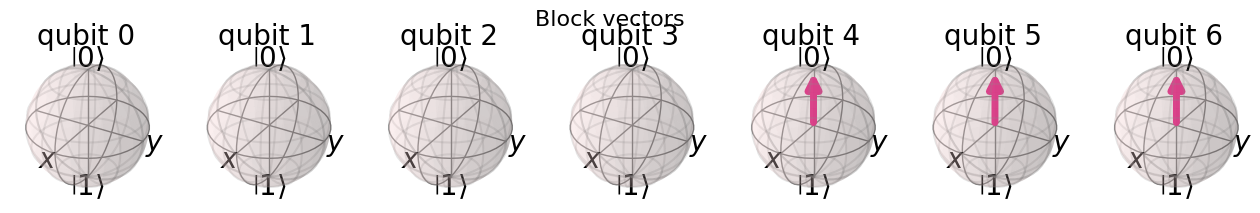

In [730]:
backend = BasicAer.get_backend('statevector_simulator') # the device to run on
result = backend.run(transpile(l_circuit4.qc, backend)).result()
psi  = result.get_statevector(l_circuit4.qc)
plot_bloch_multivector(psi, title="Block vectors")
#plot_state_qsphere(psi)

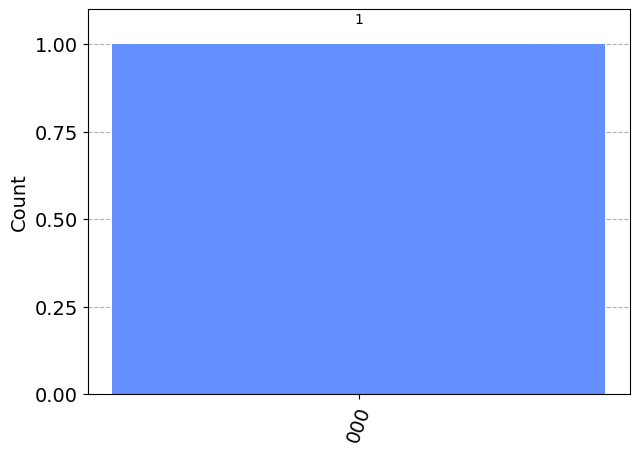

In [731]:
plot_histogram(result.get_counts(l_circuit4.qc))

## IBMQ simulation

In [732]:
#IBMQ.save_account('you_account_token', overwrite=False)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

ibmq_backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (nb_n+1) and not x.configuration().simulator and x.status().operational==True))
print(f"least busy backend: {ibmq_backend}")

ibmqfactory.load_account:WARNING:2023-04-16 22:02:16,835: Credentials are already in use. The existing account in the session will be replaced.


least busy backend: ibmq_lima


### Extra case: Use circuit 3 (Case 3) to simulate the ancilla stabilization measurement in a real Quantum Computer (IBMQ)
**NOT WORKING CURRENTLY BECAUSE MY FREE ACCOUNT IN IBMQ ONLY ALLOWS ME TO USE 5 QUBITS MAX, IN THIS CASE WE HAVE 7 + 3 CLASSICAL REGISTERS**

In [733]:
from qiskit.tools.monitor import job_monitor

transpiled_dj_circuit = transpile(l_circuit1.qc, ibmq_backend, optimization_level=3)
qobj = assemble(transpiled_dj_circuit, ibmq_backend)
ibmq_job = ibmq_backend.run(qobj, shots=1024)
job_monitor(ibmq_job, interval=2)

results = ibmq_job.result()
answer = results.get_counts()

plot_histogram(answer)

TranspilerError: 'Number of qubits (7) in circuit-808 is greater than maximum (5) in the coupling_map'